In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torchvision import datasets, transforms, models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 64

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
learning_rate = 1.0

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)

d:\ip_ai_21\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\ip_ai_21\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\litvi/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [12]:
num_epochs = 10

def train(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_loss_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        train_loss_history.append(epoch_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    return train_loss_history

In [6]:
train_loss_history = train(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Loss: 0.7113
Epoch [2/10], Loss: 0.3421
Epoch [3/10], Loss: 0.2290
Epoch [4/10], Loss: 0.1565
Epoch [5/10], Loss: 0.1181
Epoch [6/10], Loss: 0.0797
Epoch [7/10], Loss: 0.0684
Epoch [8/10], Loss: 0.0502
Epoch [9/10], Loss: 0.0386
Epoch [10/10], Loss: 0.0379


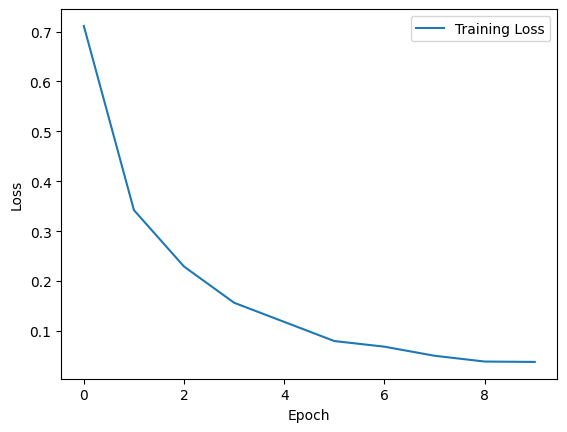

In [7]:
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    num_classes = 10

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    cm = confusion_matrix(all_labels, all_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(20, 18))
    sns.heatmap(cm_normalized, annot=False, fmt='.2f', cmap='Blues', cbar=True)

    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)
    plt.title('Confusion Matrix (Normalized)', fontsize=16)

    plt.xticks(np.arange(num_classes) + 0.5, labels=np.arange(num_classes), rotation=90, fontsize=10)
    plt.yticks(np.arange(num_classes) + 0.5, labels=np.arange(num_classes), rotation=0, fontsize=10)

    plt.tight_layout()
    plt.show()
    return accuracy

Test Accuracy: 91.93%


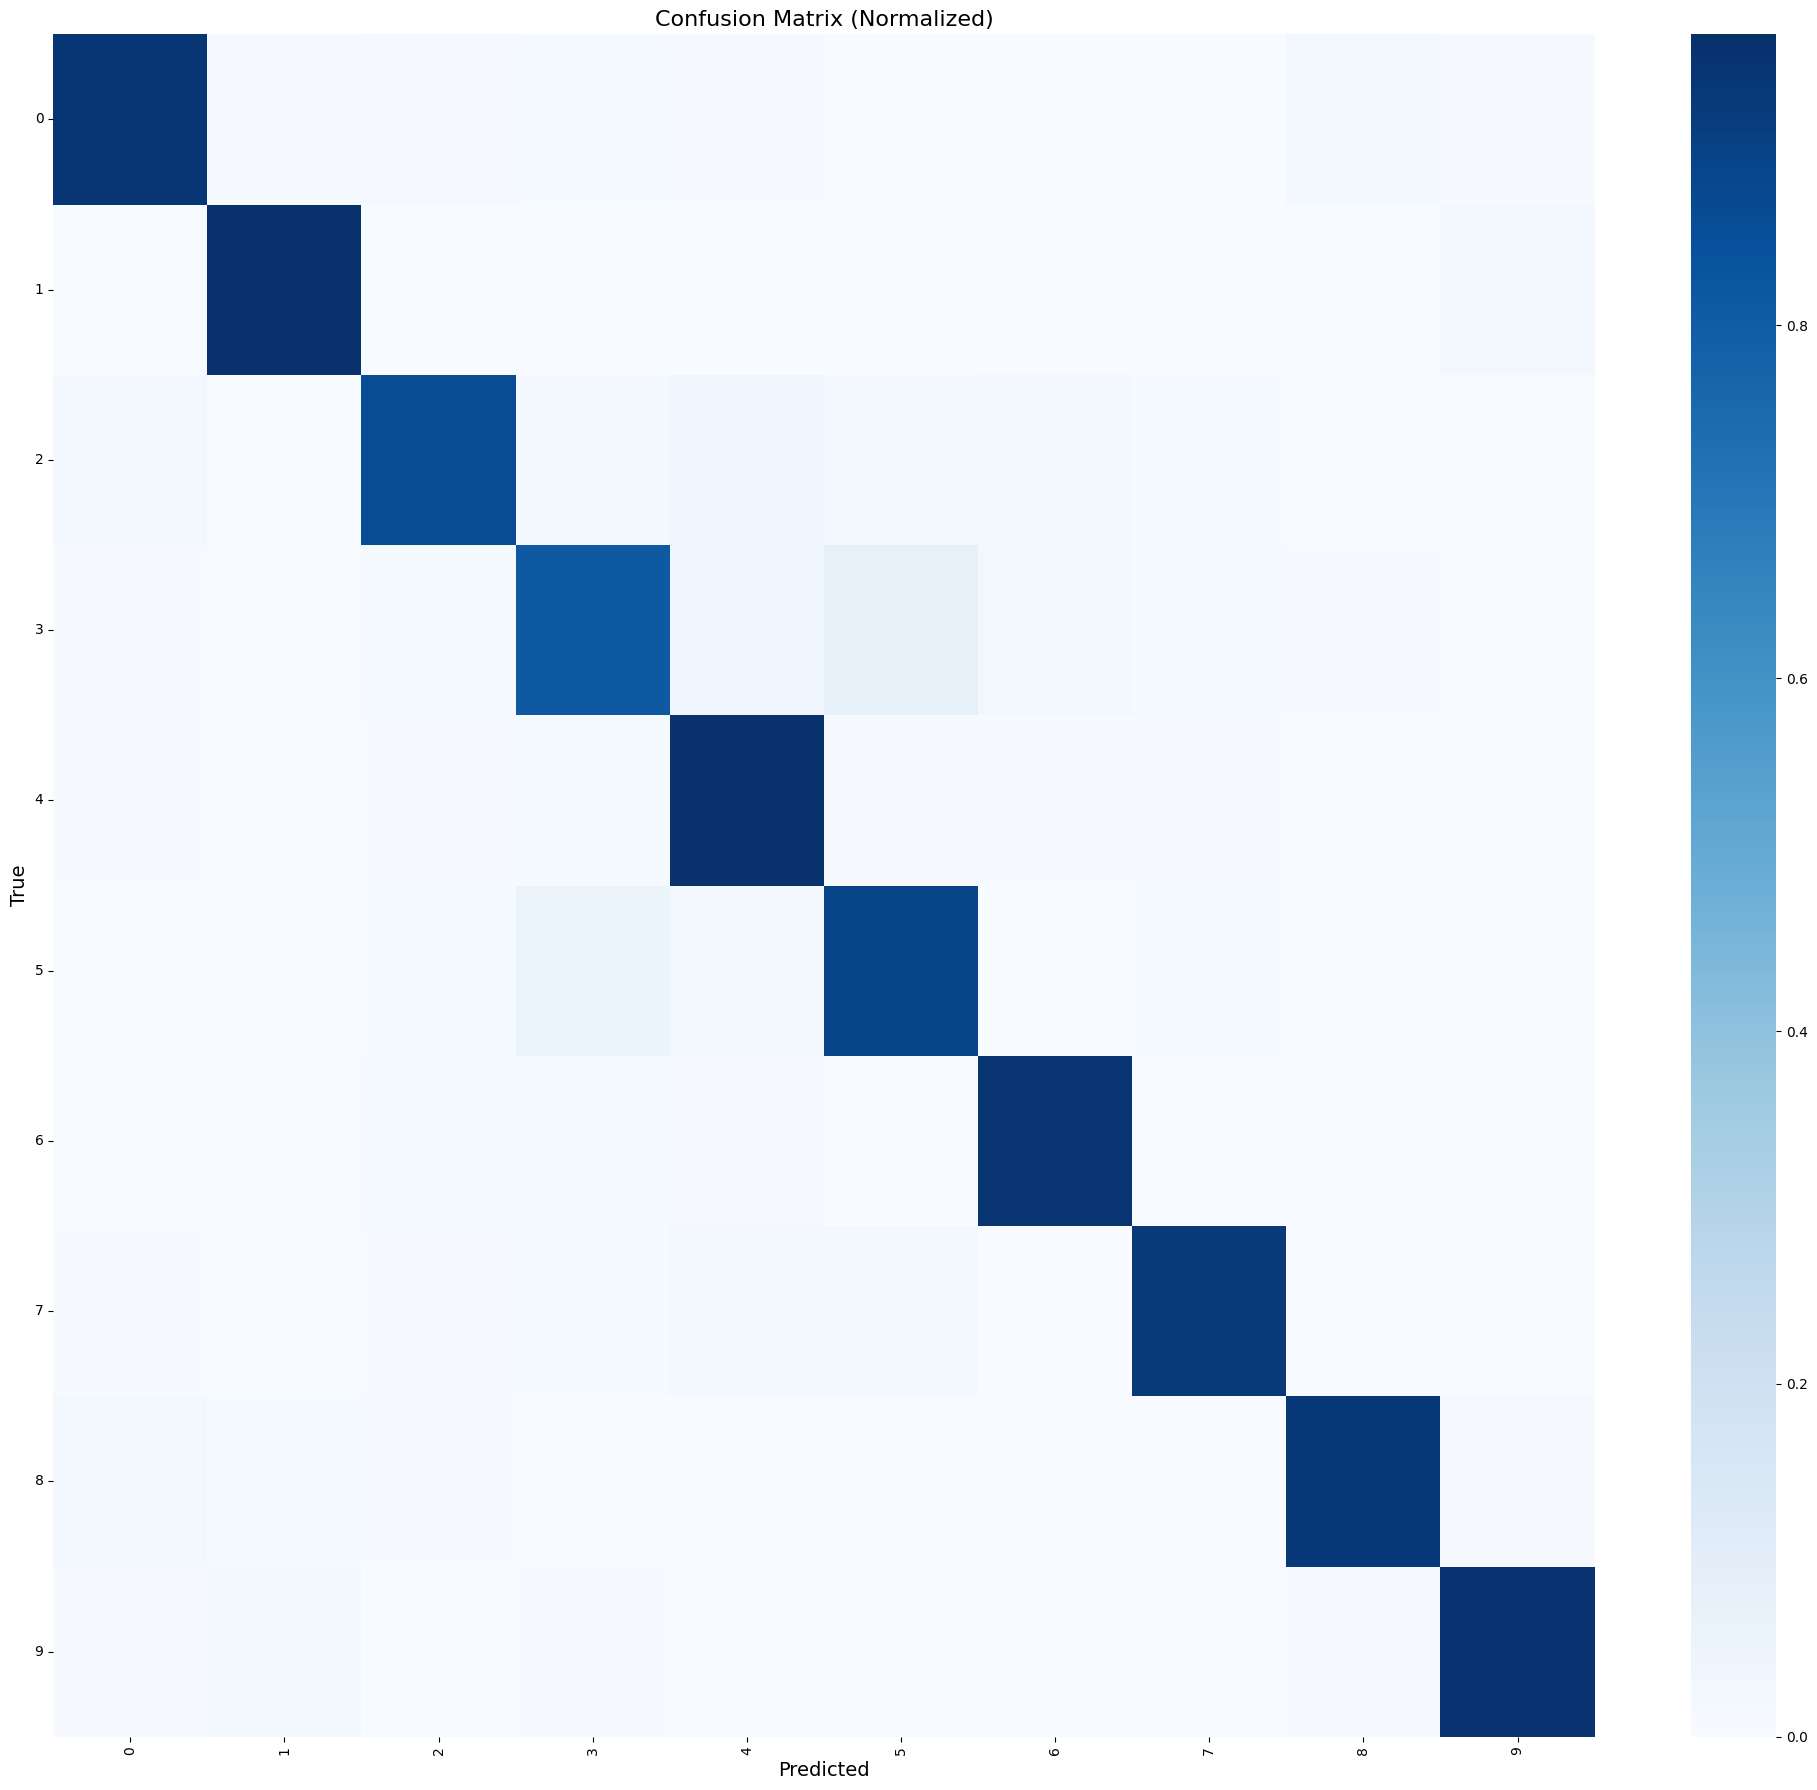

In [14]:
test_accuracy = evaluate(model, test_loader)

In [ ]:
def visualize_predictions(model, test_loader, num_images=5):
    model.eval()
    images_shown = 0
    class_names = test_dataset.classes

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown == num_images:
                    return
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                img = (img * 0.5 + 0.5)
                plt.imshow(img)
                plt.title(f'Predicted: {class_names[predicted[i]]}, Actual: {class_names[labels[i]]}')
                plt.axis('off')
                plt.show()
                images_shown += 1

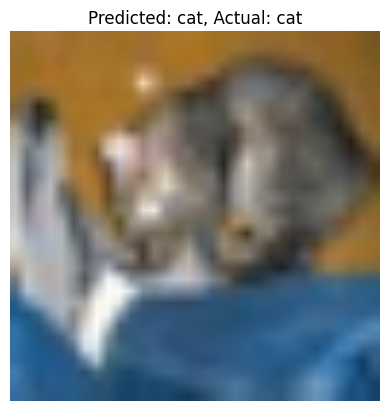

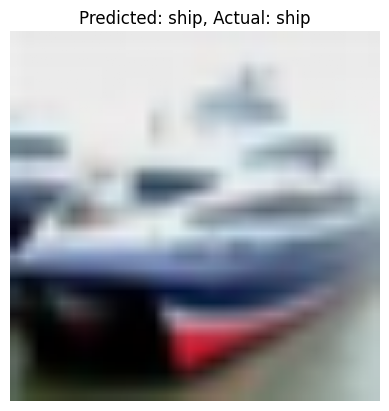

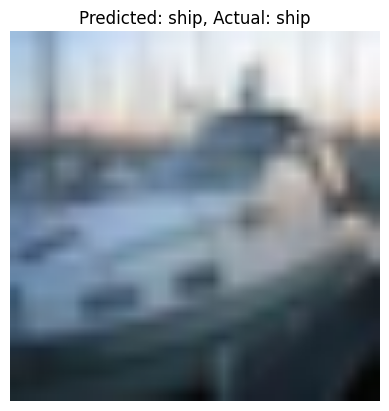

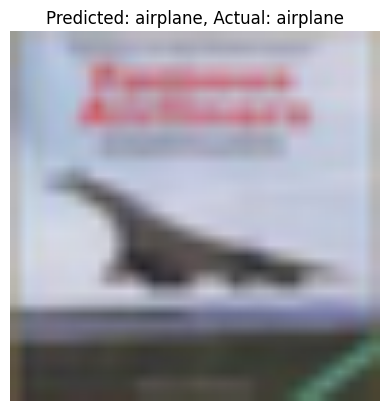

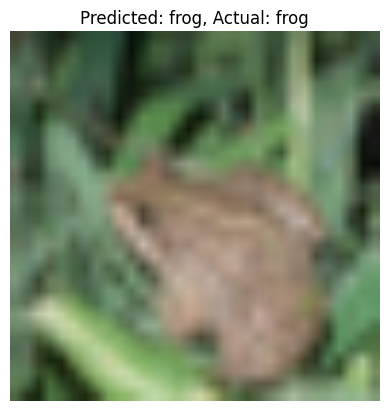

In [11]:
visualize_predictions(model, test_loader)